
# 图像分类

在该项目中，你将会对来自 [CIFAR-10 数据集](https://www.cs.toronto.edu/~kriz/cifar.html) 中的图像进行分类。数据集中图片的内容包括飞机（airplane）、狗（dogs）、猫（cats）及其他物体。你需要处理这些图像，接着对所有的样本训练一个卷积神经网络。

具体而言，在项目中你要对图像进行正规化处理（normalization)，同时还要对图像的标签进行 one-hot 编码。接着你将会应用到你所学的技能来搭建一个具有卷积层、最大池化（Max Pooling）层、Dropout  层及全连接（fully connected）层的神经网络。最后，你会训练你的神经网络，会得到你神经网络在样本图像上的预测结果。

## 下载数据

运行如下代码下载 [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)。

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [01:13, 2.32MB/s]                                                        


All files found!


## 探索数据集


为防止在运行过程中内存不足的问题，该数据集已经事先被分成了5批（batch），名为`data_batch_1`、`data_batch_2`等。每一批中都含有 *图像* 及对应的 *标签*，都是如下类别中的一种：

* 飞机
* 汽车
* 鸟
* 鹿
* 狗
* 青蛙
* 马
* 船
* 卡车

理解数据集也是对数据进行预测的一部分。修改如下代码中的 `batch_id` 和 `sample_id`，看看输出的图像是什么样子。其中，`batch_id` 代表着批次数（1-5），`sample_id` 代表着在该批内图像及标签的编号。

你可以尝试回答如下问题：
* 可能出现的 *标签* 都包括哪些？
* 图像数据的取值范围是多少？
* *标签* 的排列顺序是随机的还是有序的？

对这些问题的回答，会有助于更好地处理数据，并能更好地进行预测。


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 9999:
Image - Min Value: 4 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


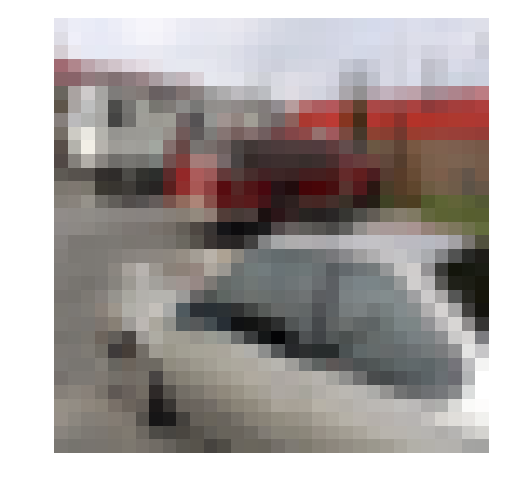

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 5
sample_id = 9999
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## 图像预处理功能的实现
### 正规化

在如下的代码中，修改 `normalize` 函数，使之能够对输入的图像数据 `x` 进行处理，输出一个经过正规化的、Numpy array 格式的图像数据。

**注意：**
处理后的值应当在 $[0,1]$ 的范围之内。返回值应当和输入值具有相同的形状。

In [10]:

def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return (x - np.min(x))/(np.max(x) - np.min(x))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot 编码

在如下代码中，你将继续实现预处理的功能，实现一个 `one_hot_encode` 函数。函数的输入 `x` 是 *标签* 构成的列表，返回值是经过 One_hot 处理过后的这列 *标签* 对应的 One_hot 编码，以 Numpy array 储存。其中，*标签* 的取值范围从0到9。每次调用该函数时，对相同的标签值，它输出的编码也是相同的。请确保在函数外保存编码的映射（map of encodings）。

**提示：**

你可以尝试使用 sklearn preprocessing 模块中的 `LabelBinarizer` 函数。

In [13]:
from sklearn.preprocessing import LabelBinarizer
# 预先训练好encoder，确保一定会编码为十类
lb = LabelBinarizer()
lb.fit([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    return lb.transform(x)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### 随机打乱数据

正如你在上方探索数据部分所看到的，样本的顺序已经被随机打乱了。尽管再随机处理一次也没问题，不过对于该数据我们没必要再进行一次相关操作了。

## 对所有图像数据进行预处理并保存结果

运行如下代码，它将会预处理所有的 CIFAR-10 数据并将它另存为文件。此外，如下的代码还将会把 10% 的训练数据留出作为验证数据。

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# 检查点

这是你的首个检查点。因为预处理完的数据已经被保存到硬盘上了，所以如果你需要回顾或重启该 notebook，你可以在这里重新开始。

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

print("features Dimension: ", valid_features.shape)
print("labels Dimension", valid_labels.shape)
print("Example: label for #0 image is", valid_labels[0,:])

features Dimension:  (5000, 32, 32, 3)
labels Dimension (5000, 10)
Example: label for #0 image is [0 0 0 0 1 0 0 0 0 0]


## 搭建神经网络

为搭建神经网络，你需要将搭建每一层的过程封装到一个函数中。大部分的代码你在函数外已经见过。为能够更透彻地测试你的代码，我们要求你把每一层都封装到一个函数中。这能够帮助我们给予你更好的回复，同时还能让我们使用 unittests 在你提交报告前检测出你项目中的小问题。

>**注意：** 如果你时间紧迫，那么在该部分我们为你提供了一个便捷方法。在接下来的一些问题中，你可以使用来自 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的函数来搭建各层，不过不可以用他们搭建卷积-最大池化层。TF Layers 和 Keras 及 TFLean 中对层的抽象比较相似，所以你应该很容易上手。

> 不过，如果你希望能够更多地实践，我们希望你能够在**不**使用 TF Layers 的情况下解决所有问题。你依然**能**使用来自其他包但和 layers 中重名的函数。例如，你可以使用 TF Neural Network 版本的 `conv_2d`[tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

让我们开始吧！

### 输入

神经网络需要能够读取图像数据、经 one-hot 编码之后的标签及 dropout 中的保留概率。修改如下函数：

* 修改 `neural_net_image_input` 函数：
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)。
 * 使用 `image_shape` 设定形状，设定批大小（batch size)为 `None`。
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 `Name` 参数，命名该 TensorFlow placeholder 为 "x"。


* 修改 `neural_net_label_input` 函数： 
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)。
 * 使用 `n_classes` 设定形状，设定批大小（batch size)为 `None`。
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 `Name` 参数，命名该 TensorFlow placeholder 为 "y"。


* 修改 `neural_net_keep_prob_input` 函数：
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 作为 dropout 的保留概率（keep probability）。
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 `Name` 参数，命名该 TensorFlow placeholder 为 "keep_prob"。
 
我们会在项目最后使用这些名字，来载入你储存的模型。

**注意：**在 TensorFlow 中，对形状设定为 `None`，能帮助设定一个动态的大小。

In [2]:
import tensorflow as tf

# 整个网络的输入尺寸：
# 第一维：batch的大小（就是样本数量，比如128张样本图）
# 第二维：长
# 第三维：宽
# 第四维：颜色通道数（一般都是RGB图片，因此是三个通道）
def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape=[None, image_shape[0], image_shape[1], image_shape[2]], name='x')
    # 用加号性质合并，语法更简洁
    return tf.placeholder(tf.float32, shape=[[None,] + image_shape], name='x')
    # TensorFlow的shape参数既允许list也允许tuple类型
    return tf.placeholder(tf.float32, shape=((None,) + image_shape), name='x')   

# 整个网络的输出结果
# 第一维：样本（对应于输入的每一张样本图）
# 第二维：分类号（由于采用onehot编码，因此有多少种分类这个维度就有多长）
def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')

# Drop-out专用
def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, name='keep_prob')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### 卷积-最大池（Convolution and Max Pooling）化层

卷积层在图像处理中取得了不小的成功。在这部分的代码中，你需要修改 `conv2d_maxpool` 函数来先后实现卷积及最大池化的功能。

* 使用 `conv_ksize`、`conv_num_outputs` 及 `x_tensor` 来创建权重（weight）及偏差（bias）变量。
* 对 `x_tensor` 进行卷积，使用 `conv_strides` 及*权重*。
 * 我们建议使用 SAME padding，不过你也可尝试其他 padding 模式。 


* 加上*偏差*。
* 对卷积结果加上一个非线性函数作为激活层。
* 基于 `pool_ksize` 及 `pool_strides` 进行最大池化。
 * 我们建议使用 SAME padding，不过你也可尝试其他 padding 模式。


**注意：**
你**不**可以使用来自 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的函数来实现**这一层**的功能。但是你可以使用 TensorFlow 的[Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn)包。

对于如上的快捷方法，你在**其他层**中可以尝试使用。


**提示：**
当你在 Python 中希望展开（unpacking）某个变量的值作为函数的参数，你可以参考 [unpacking](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists) 运算符。

In [3]:
# 权重初始值的方差会影响准确率
global_stddev = 0.01

In [4]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # 初始化卷积层的weight和bias矩阵
    # x_tensor shape = [batch, height, width, depth]
    # weight = height * width * depth * output ~ init at normal distribution N(0, 0.01)
    # bias = output ~ init at 0
    depth = x_tensor.shape[3].value
    weight_shape = [conv_ksize[0], conv_ksize[1], depth, conv_num_outputs]
    weight_init_val = tf.truncated_normal(weight_shape, mean=0, stddev=global_stddev)
    # Define variables
    weight = tf.Variable(weight_init_val)
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    # 执行二维卷积（根据给定输入以及滤波器尺寸、扫描方式）
    # stride = [batch, height, width, depth]
    # Apply stride only to height and width: [1, x, x, 1]
    stride = [1, conv_strides[0], conv_strides[1], 1]
    y = tf.nn.conv2d(input=x_tensor, filter=weight, strides=stride, padding='SAME')
    y = tf.nn.bias_add(y, bias)
    
    # 送入非线性激活函数产生概率值
    y = tf.nn.relu(y)
    
    # 用最大池化处理数据（根据给定的池化滤波器尺寸和扫描方式）
    filter_shape = [1, pool_ksize[0], pool_ksize[1], 1]
    stride = [1, pool_strides[0], pool_strides[1], 1]
    y = tf.nn.max_pool(y, ksize=filter_shape, strides=stride, padding='SAME')
    
    # 返回最后的输出结果
    return y


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### 展开层

修改 `flatten` 函数，来将4维的输入张量 `x_tensor` 转换为一个二维的张量。输出的形状应当是 `(Batch Size, Flattened Image Size)`。
快捷方法：你可以使用来自 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的函数来实现该功能。不过你也可以只使用 TensorFlow 包中的函数来挑战自己。

In [5]:
import numpy as np
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    # 获得输入矩阵在所有维度上的长度值的list
    # 例如x如果有128张图，长乘宽是32x32，有RGB三个颜色通道，那么x_shape = [128, 32, 32, 3]
    x_shape = x_tensor.shape.as_list()

    # 把后三个维度压缩为一个维度，用一个向量表示一张图的所有像素信息
    img_len = np.prod(x_shape[1:])
    
    # OPT1：用-1自由推断维度长度
    return tf.reshape(x_tensor, shape=[-1, img_len])

    # OPT2：用原有shape对象，不可以直接用x_shape[0]，因为类型不同
    return tf.reshape(x_tensor, shape=[tf.shape(x_tensor)[0], img_len])

    # OPT3：直接调用API将x_tensor变形为[batch, k]
    return tf.contrib.layers.flatten(x_tensor)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### 全连接层

修改 `fully_conn` 函数，来对形如 `(batch Size, num_outputs)` 的输入 `x_tensor` 应用一个全连接层。快捷方法：你可以使用来自 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的函数来实现该功能。不过你也可以只使用 TensorFlow 包中的函数来挑战自己。

In [6]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # OPT1：实现全链接的隐藏层。其实就是标准的矩阵乘法形式。
    # 因为已知 input = batch * K，output = batch * num_outputs, 因此可以推测出 weight = K * num_outputs
    weight = tf.Variable(tf.truncated_normal([x_tensor.shape[1].value, num_outputs], mean=0, stddev=global_stddev))
    bias = tf.Variable(tf.zeros(num_outputs))
    y = tf.matmul(x_tensor, weight)        # b,k * k,n = b,n
    y = tf.add(y, bias)
    y = tf.nn.relu(y)
    return y
    
    # OPT2：直接调用API将x_tensor经过全链接层输出为num_outputs个输出，默认使用ReLU作为激励函数
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=tf.nn.relu)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### 输出层

修改 `output` 函数，来对形如 `(batch Size, num_outputs)` 的输入 `x_tensor` 应用一个全连接层。快捷方法：你可以使用来自 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的函数来实现该功能。不过你也可以只使用 TensorFlow 包中的函数来挑战自己。

**注意：**
激活函数、softmax 或者交叉熵（corss entropy）**不**应被加入到该层。

In [7]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # OPT1：实现全链接的隐藏层。其实就是标准的矩阵乘法形式。
    weight = tf.Variable(tf.truncated_normal([x_tensor.shape[1].value, num_outputs], mean=0, stddev=global_stddev))
    bias = tf.Variable(tf.zeros(num_outputs))
    y = tf.matmul(x_tensor, weight)
    y = tf.add(y, bias)
    return y
    
    # OPT2：直接调用API将x_tensor通过全链接层输出，不经过任何激励函数。
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=None)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### 创建卷积模型

修改 `conv_net` 函数，使之能够生成一个卷积神经网络模型。该函数的输入为一批图像数据 `x`，输出为 logits。在函数中，使用上方你修改的创建各种层的函数来创建该模型：

* 使用 1 到 3 个卷积-最大池化层
* 使用一个展开层
* 使用 1 到 3 个全连接层
* 使用一个输出层
* 返回输出结果
* 在一个或多个层上使用 [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)，对应的保留概率为 `keep_prob`. 

In [138]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # 卷积池化层
    # 可调参数列表
    # 0. 层数：不断调用并串联conv2d_maxpool，且每一层可以调整下面五个参数：
    # 1. 输出特征个数：conv_num_outputs
    # 2. 卷积滤波器二维尺寸：conv_ksize
    # 3. 卷积滤波器二维步长：conv_strides
    # 4. 池化滤波器二维尺寸：pool_ksize
    # 5. 池化滤波器二维步长：pool_strides
    # 函数签名：conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    x_after_pool = x
    x_after_pool = conv2d_maxpool(x_after_pool, 16, [3, 3], [1, 1], [2, 2], [1, 1])
    x_after_pool = conv2d_maxpool(x_after_pool, 16, [3, 3], [1, 1], [2, 2], [1, 1])
    x_after_pool = conv2d_maxpool(x_after_pool, 16, [3, 3], [1, 1], [2, 2], [1, 1])
    
    # 展开层
    x_after_flatten = flatten(x_after_pool)

    # 全链接层
    # 可调参数列表
    # 层数：串联fully_conn
    # 输出特征个数：num_outputs
    # 函数签名：fully_conn(x_tensor, num_outputs)
    x_after_full_conn = fully_conn(x_after_flatten, 1024)

    
    # Dropout：在全链接层和输出层之间进行
    x_after_dropout = tf.nn.dropout(x_after_full_conn, keep_prob)
    
    # 输出层
    # 输出特征个数为10，对应于实际要分类的10个one-hot特征
    y = output(x_after_dropout, 10)
    
    return y


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# 给输出结果起个名字方便后续调用
# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# 代价函数：使用交叉熵作为代价函数
# 对代价函数进行最优化：AdamOptimizer，一种SGD方法
# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# 定义评估指标: 准确率
# 扫描每个图像，比较估计值和真实值label沿第二维的最大值索引
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))    
# 求平均
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## 训练该神经网络

### 最优化

修改 `train_neural_network` 函数以执行单次最优化。该最优化过程应在一个 `session` 中使用 `optimizer` 来进行该过程，它的 `feed_dict` 包括：
* `x` 代表输入图像
* `y` 代表*标签*
* `keep_prob` 为 Dropout 过程中的保留概率

对每批数据该函数都会被调用，因而 `tf.global_variables_initializer()` 已经被调用过。

注意：该函数并不要返回某个值，它只对神经网络进行最优化。

In [9]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### 显示状态

修改 `print_stats` 函数来打印 loss 值及验证准确率。 使用全局的变量 `valid_features` 及 `valid_labels` 来计算验证准确率。 设定保留概率为 1.0 来计算 loss 值及验证准确率。

In [10]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # 此时已经对模型训练完一批数据
    # 查看模型对当前训练集的预测值与真实值之间的差距（交叉熵）
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1})
    
    # 查看模型对当前训练集的预测准确度
    acc = session.run(accuracy, feed_dict={x:valid_features, y:valid_labels, keep_prob:1})
    
    # 实时显示
    print("loss =", loss, "   accuracy =", round(acc*100, 2), "%")

### 超参数调节

你需要调节如下的参数：
* 设定 `epoches` 为模型停止学习或开始过拟合时模型的迭代次数。
* 设定 `batch_size` 为你内存能支持的最大值。一般我们设定该值为：
 * 64
 * 128
 * 256
 * ...
 
 
* 设定 `keep_probability` 为在 dropout 过程中保留一个节点的概率。

In [143]:
# TODO: Tune Parameters
# 15代基本能稳定在55%
epochs = 15

# batch_size越大，每个epoch调用train_neural_network的频率就越低（稍微快些），但是会导致早几代的准确率下降(收敛速度下降)
# 1080ti似乎可以支持到1024
# 注意batch_size过大导致OOM之后，需要重新运行checkpoint后的所有代码才可以，否则会持续OOM。
batch_size = 512

# 减弱过拟合
keep_probability = 0.5

global_stddev = 0.1

### 对单批 CIFAR-10 数据进行训练

相比于在所有 CIFAR-10 数据上训练神经网络，我们首先使用一批数据进行训练。这会帮助你在调节模型提高精度的过程中节省时间。当最终的验证精度超过 50% 之后，你就可以前往下一节在所有数据上运行该模型了。

In [89]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from time import time
print('Checking the Training on a Single Batch...')

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # 对五万张照片中的第一批（10000张）照片进行训练，每次选择9000张作为训练集。
    start = time()
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)
    end = round(time() - start, 2)
    print("Time Spent:", end)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  loss = 2.01225    accuracy = 36.4 %
Epoch  2, CIFAR-10 Batch 1:  loss = 1.8636    accuracy = 42.14 %
Epoch  3, CIFAR-10 Batch 1:  loss = 1.73107    accuracy = 45.02 %
Epoch  4, CIFAR-10 Batch 1:  loss = 1.71657    accuracy = 45.78 %
Epoch  5, CIFAR-10 Batch 1:  loss = 1.63374    accuracy = 48.2 %
Epoch  6, CIFAR-10 Batch 1:  loss = 1.46242    accuracy = 49.16 %
Epoch  7, CIFAR-10 Batch 1:  loss = 1.40084    accuracy = 48.76 %
Epoch  8, CIFAR-10 Batch 1:  loss = 1.35205    accuracy = 50.6 %
Epoch  9, CIFAR-10 Batch 1:  loss = 1.31065    accuracy = 48.5 %
Epoch 10, CIFAR-10 Batch 1:  loss = 1.14954    accuracy = 51.08 %
Epoch 11, CIFAR-10 Batch 1:  loss = 1.13003    accuracy = 49.52 %
Epoch 12, CIFAR-10 Batch 1:  loss = 1.07696    accuracy = 50.78 %
Epoch 13, CIFAR-10 Batch 1:  loss = 1.04031    accuracy = 51.9 %
Epoch 14, CIFAR-10 Batch 1:  loss = 0.996598    accuracy = 52.14 %
Epoch 15, CIFAR-10 Batch 1:  loss = 0.

## 参数与模型性能的关系探索

### epoch 

- 代数越多，模型的准确度会趋近于越好，并收敛于一个值左右，上下震动。


- 当准确度不再随epoch增长而增长时，模型就算收敛了。再往下训练有可能发展为过拟合。

| epoch | batch_size | prob | stddev | accuracy |
| ----- | ---------- | ---- | ------ | -------- |
| **#1**  | 512        | 0.5  | 0.01 | **26%**  |
| **#2**  | 512        | 0.5  | 0.01 | **33%**  |
| **#3**  | 512        | 0.5  | 0.01 | **39%**  |
| **#4**  | 512        | 0.5  | 0.01 | **42%**  |
| **#5**  | 512        | 0.5  | 0.01 | **45%**  |
| **#10** | 512        | 0.5  | 0.01 | **52%**  |
| **#15** | 512        | 0.5  | 0.01 | **54%**  |
| **#20** | 512        | 0.5  | 0.01 | **54%**  |
| **#25** | 512        | 0.5  | 0.01 | **56%**  |
| **#30** | 512        | 0.5  | 0.01 | **57%**  |
| **#35** | 512        | 0.5  | 0.01 | **56%**  |
| **#40** | 512        | 0.5  | 0.01 | **57%**  |

以上结果基于模型参数:
- 卷积层：输出个数 128, 滤波器尺寸 [3, 3], 滤波器步长 [1, 1], 池化尺寸 [2, 2], 池化步长 [1, 1]
- 全链接层：输出个数 512

### `batch_size` 

- 结论：`batch_size` 会影响训练时间，但不会影响准确率

| time (sec) | epoch | batch_size | prob | stddev | accuracy |
| ---------- | ----- | ---------- | ---- | ------ | -------- |
| **80**     | 35    | **1024**   | 0.5  | 0.01   | 55% (start at 20%) |
| **83**     | 35    | **512**    | 0.5  | 0.01   | 55% (start at 25%) |
| **93**     | 35    | **256**    | 0.5  | 0.01   | 55% (start at 26%) |
| **116**    | 35    | **128**    | 0.5  | 0.01   | 55% (start at 32%) |
| **161**    | 35    | **64**     | 0.5  | 0.01   | 55% (start at 39%) |

以上结果基于模型参数:
- 卷积层：输出个数 128, 滤波器尺寸 [3, 3], 滤波器步长 [1, 1], 池化尺寸 [2, 2], 池化步长 [1, 1]
- 全链接层：输出个数 512

### `stddev` 

- `stddev` 过小会导致收敛过慢。达到相同准确率需要更多轮训练时间。

| time (sec) | epoch | batch_size | prob | stddev | accuracy |
| ---------- | ----- | ---------- | ---- | ------ | -------- |
| **34**     | **15**    | 1024       | 0.5  | **0.01**   | 55%      |
| **80**     | **35**    | 1024       | 0.5  | **0.001**  | 55%      |


- `stddev` 过大会导致欠拟合

| time (sec) | epoch | batch_size | prob | stddev | accuracy |
| ---------- | ----- | ---------- | ---- | ------ | -------- |
| 80         | 35    | 1024       | 0.5  | **0.01**   | **55%**      |
| 80         | 35    | 1024       | 0.5  |  **0.1**   | **55%**      |
| 80         | 35    | 1024       | 0.5  |    **1**   | **11%**      |

以上结果基于模型参数:
- 卷积层：输出个数 128, 滤波器尺寸 [3, 3], 滤波器步长 [1, 1], 池化尺寸 [2, 2], 池化步长 [1, 1]
- 全链接层：输出个数 512

### keep_probability

- 调小每个节点的保留概率可以缓解过拟合的情况


- 但如果保留概率过小，则会出现欠拟合。

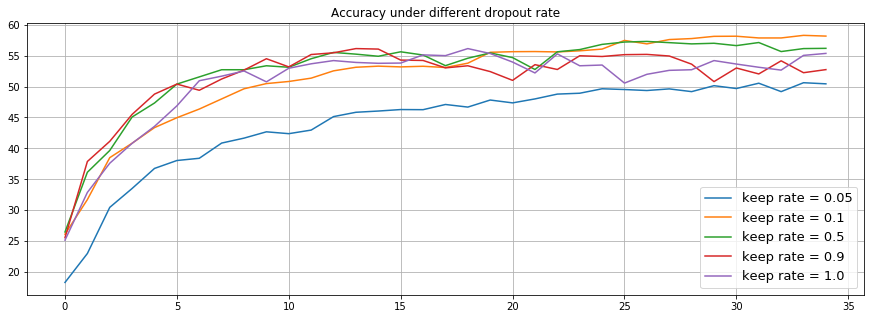

In [38]:
import matplotlib.pyplot as plt
idx = np.arange(35)
res_005 = [18.32,23.0,30.46,33.52,36.76,38.04,38.4,40.86,41.66,42.68,42.38,42.96,45.14,45.84,46.04,46.28,46.26,47.1,46.68,47.82,47.36,48.0,48.78,48.92,49.64,49.52,49.36,49.62,49.18,50.14,49.68,50.54,49.18,50.62,50.44]
res_01 = [26.12, 31.72, 38.5, 40.84, 43.36, 44.96, 46.36, 48.0, 49.64, 50.48, 50.82, 51.36, 52.54, 53.12, 53.3, 53.18, 53.28, 53.08, 53.78, 55.54, 55.64, 55.66, 55.6, 55.78, 56.06, 57.46, 56.9, 57.6, 57.76, 58.12, 58.14, 57.86, 57.86, 58.28, 58.16]
res_05 = [26.48,36.14,39.66,45.08,47.34,50.4,51.56,52.72,52.72,53.36,53.12,54.5,55.52,55.24,54.9,55.62,55.1,53.38,54.58,55.44,54.68,52.76,55.62,55.98,56.82,57.2,57.3,57.1,56.9,57.0,56.62,57.12,55.66,56.14,56.18]
res_09 = [25.56,37.88,41.14,45.5,48.78,50.4,49.4,51.22,52.66,54.5,53.18,55.18,55.46,56.14,56.06,54.28,54.22,53.02,53.36,52.42,51.0,53.54,52.76,54.98,54.86,55.16,55.2,54.94,53.62,50.8,53.0,52.04,54.16,52.24,52.74]
res_10 = [25.16,32.88,37.6,40.82,43.56,46.88,50.94,51.68,52.52,50.76,52.96,53.68,54.2,53.9,53.76,53.8,55.12,55.0,56.14,55.34,53.96,52.2,55.28,53.36,53.48,50.56,51.98,52.62,52.72,54.2,53.64,53.12,52.66,55.04,55.36]
plt.figure(figsize=(15,5))
plt.plot(idx, res_005, label='keep rate = 0.05')
plt.plot(idx, res_01, label='keep rate = 0.1')
plt.plot(idx, res_05, label='keep rate = 0.5')
plt.plot(idx, res_09, label='keep rate = 0.9')
plt.plot(idx, res_10, label='keep rate = 1.0')   # No dropout
plt.title("Accuracy under different dropout rate")
plt.legend(fontsize=13)
plt.grid(True)
plt.show()


### 完全训练该模型

因为你在单批 CIFAR-10 数据上已经得到了一个不错的准确率了，那你可以尝试在所有五批数据上进行训练。

In [139]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    start = time()
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
    end = round(time() - start, 2)
    print("Time Spent:", end)        
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  loss = 2.09307    accuracy = 28.66 %
Epoch  1, CIFAR-10 Batch 2:  loss = 1.7693    accuracy = 35.7 %
Epoch  1, CIFAR-10 Batch 3:  loss = 1.59276    accuracy = 39.3 %
Epoch  1, CIFAR-10 Batch 4:  loss = 1.52608    accuracy = 42.88 %
Epoch  1, CIFAR-10 Batch 5:  loss = 1.57057    accuracy = 45.24 %
Epoch  2, CIFAR-10 Batch 1:  loss = 1.57112    accuracy = 45.5 %
Epoch  2, CIFAR-10 Batch 2:  loss = 1.38283    accuracy = 48.64 %
Epoch  2, CIFAR-10 Batch 3:  loss = 1.23539    accuracy = 49.14 %
Epoch  2, CIFAR-10 Batch 4:  loss = 1.28118    accuracy = 49.94 %
Epoch  2, CIFAR-10 Batch 5:  loss = 1.25992    accuracy = 52.32 %
Epoch  3, CIFAR-10 Batch 1:  loss = 1.31034    accuracy = 52.9 %
Epoch  3, CIFAR-10 Batch 2:  loss = 1.18839    accuracy = 54.54 %
Epoch  3, CIFAR-10 Batch 3:  loss = 1.04468    accuracy = 54.14 %
Epoch  3, CIFAR-10 Batch 4:  loss = 1.07237    accuracy = 56.6 %
Epoch  3, CIFAR-10 Batch 5:  loss = 1.04407    accuracy = 56.72 %
Epoc

### 卷积层输出个数

- conv_num_ouput 越大，训练耗时越大，但准确率没有明显变化。

| time (sec) | 卷积层输出 | 卷积层尺寸 | 卷积层步长 | 池化层尺寸 | 池化层步长 | 全链接层输出 | 准确率    |
| ---------- | -------- | --------- | -------- | -------- | -------- | ----------- | -------- |
| **54**     | **8**    | [3,3]     |    1     |   [2,2]  | 1        |    128     |     **61%**   |
| **58**     | **16**   | [3,3]     |    1     |   [2,2]  | 1        |    128     |     **62%**   |
| **67**     | **32**   | [3,3]     |    1     |   [2,2]  | 1        |    128     |     **62%**   |
| **91**     | **64**   | [3,3]     |    1     |   [2,2]  | 1        |    128     |     **62%**   |
| **131**    | **128**  | [3,3]     |    1     |   [2,2]  | 1        |    128     |     **61%**   |

- 以上结果基于以下参数:
    - 训练代数 epoch 15
    - batch_size = 64
    - keep_prob = 0.5
    - stddev = 0.01

### 全链接层输出个数

- full_num_ouput 越大，准确率有稳定的明显提升

| time (sec) | 卷积层输出 | 卷积层尺寸 | 卷积层步长 | 池化层尺寸 | 池化层步长 | 全链接层输出 | 准确率 | 达到60%准确率的代数 |
| ---------- | -------- | --------- | -------- | -------- | -------- | ----------- | -------- | --------------|
| **66**     | 16       | [3,3]     |    1     |   [2,2]  | 1        |  **64**    |   **59%** | N/A
| **56**     | 16       | [3,3]     |    1     |   [2,2]  | 1        |  **128**   |   **62%** | #8
| **60**     | 16       | [3,3]     |    1     |   [2,2]  | 1        |  **256**   |   **63%** | #5
| **66**     | 16       | [3,3]     |    1     |   [2,2]  | 1        |  **512**   |   **64%** | #3
| **82**     | 16       | [3,3]     |    1     |   [2,2]  | 1        |  **1024**  |   **65%** | #3

- 以上结果基于以下参数:
    - 训练代数 epoch 15
    - batch_size = 64
    - keep_prob = 0.5
    - stddev = 0.01

### 卷积层串联个数

- 将卷积层多层级联可以提升准确率。

| time (sec) | 卷积层输出 | 卷积层尺寸 | 卷积层步长 | 池化层尺寸 | 池化层步长 | 全链接层输出 | 准确率 |
| ---------- | -------- | --------- | -------- | -------- | -------- | ----------- | -------- |
| **66**  | **16**       | [3,3]     |    1     |   [2,2]  | 1        |  1024    |   **65%** |
| **120** | **16,16**    | [3,3]     |    1     |   [2,2]  | 1        |  1024    |   **66%** |
| **212** | **16,16,16** | [3,3]     |    1     |   [2,2]  | 1        |  1024    |   **67%** |
| **260** | **16,16,16,16,16** | [3,3]     |    1     |   [2,2]  | 1  |  1024    |   **64%** |

### 全链接层串联个数

尝试了增加全链接层的级联个数，但是没有明显的准确率提升。

### 卷积滤波器尺寸

测试微调滤波器的尺寸 [2 x 2], [3 x 3], [4 x 4], [8 x 8]，结果显示 [3 x 3] 最好。

### 再次讨论batch_size的影响

- 在后期调整模型参数的时候，一开始使用的batch_size都是64，从训练上看，收敛速度相当快，甚至能够达到第2代训练就能上60%，不过相对的完整15代训练时间要200多秒才能完成三层卷积层的模型。


- 后来想起来batch_size能够影响速度，就将batch_size升至512，训练速度可以减少到65秒，很爽，不过同时也发现收敛速度变慢，需要到第5代才能爬升到60%的准确率。


综上所述，观察到batch_size会影响收敛速率和训练速度。

# 检查点

该模型已经被存储到你的硬盘中。

## 测试模型

这部分将在测试数据集上测试你的模型。这边得到的准确率将作为你的最终准确率。你应该得到一个高于 50% 准确率。如果它没有超过 50%，那么你需要继续调整模型架构及参数。

(10000, 32, 32, 3)
INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6753159463405609



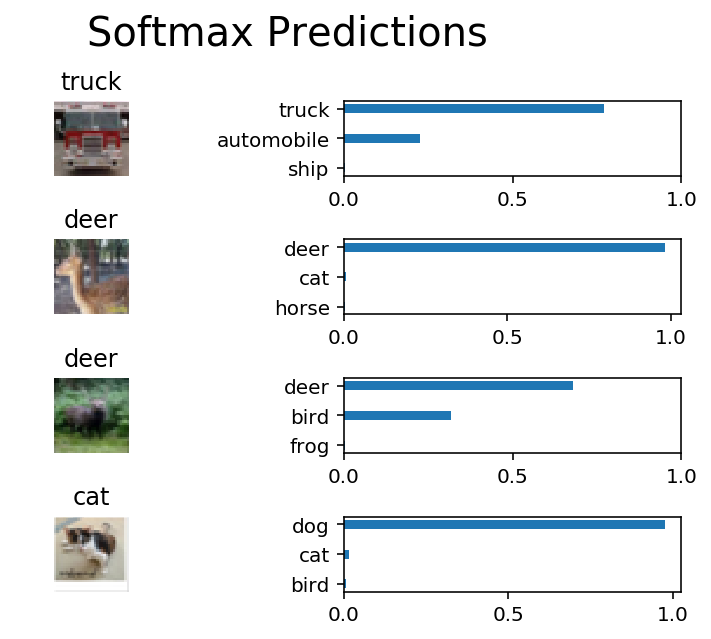

In [142]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    # 拿到相应的验证集专用数据
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    print(test_features.shape)
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

### 测试结果

> Testing Accuracy: 0.6753159463405609

可以看到，经过对每个可调参数的fine tune，最终使用以下参数搭配达到了**67%**的准确度。准备尝试一些新的方法，进一步提升准确度。

- epoch = 15
- batch_size = 64
- keep_prob = 0.5
- stddev = 0.01
- 卷积层输出结构：16, 16, 16 (三层级联)
- 卷积层激活函数：ReLU
- 卷积滤波器尺寸：3 x 3
- 卷积滤波器步长：1
- 池化滤波器尺寸：2 x 2
- 池化滤波器步长：1
- 全链接层输出结构：1024 （单层）
- 全链接层激活函数：ReLU
- Padding：SAME Padding

## 为什么仅有 50%~ 80% 的准确率？

你也许会觉得奇怪，为什么你的准确率总是提高不上去。对于简单的 CNN 网络而言，50% 并非是很差的表现。纯粹的猜测只会得到 10% 的准确率（因为一共有 10 类）。这是因为还有许多许多能够应用到你模型的技巧。在你做完了该项目之后，你可以探索探索我们给你推荐的一些方法。


## 提交该项目

在提交项目前，请确保你在运行了所有的 cell 之后保存了项目。将项目储存为 "image_classification.ipynb" 并导出为一个 HTML 文件。你可以再菜单栏中选择 File -> Download as 进行导出。请将 "helper.py" 及  "problem_unittests.py" 文件也放在你的提交文件中。